In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
import os

%matplotlib inline

In [2]:
etf_legend = pd.read_csv('../input/stockprice/etf_legend.csv')
stock_legend = pd.read_csv('../input/stockprice/stock_legend.csv')
os.chdir('../input/price-volume-data-for-all-us-stocks-etfs')
# for i in stock_legend['Name']:
#     print(stock_legend.Sym[stock_legend[stock_legend.Name==i].index[0]])

In [4]:
#### Input params ##################
# stk_path = "../input/stockprice/data/VTI.csv"
test_size = 0.1                # proportion of dataset to be used as test set
cv_size = 0.1                  # proportion of dataset to be used as cross-validation set
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

In [5]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [6]:
def modify_df(df):
    # Convert Date column to datetime
    df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

    # Change all column headings to be lower case, and remove spacing
    df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
    df.drop(['openint'], axis=1, inplace=True)

    df['adj_close'] = df['close']
    # Get month of each sample
    df['month'] = df['date'].dt.month

    # Sort by datetime
    df.sort_values(by='date', inplace=True, ascending=True)
    
    # Get difference between high and low of each day
    df['range_hl'] = df['high'] - df['low']
    df.drop(['high', 'low'], axis=1, inplace=True)

    # Get difference between open and close of each day
    df['range_oc'] = df['open'] - df['close']
    df.drop(['open', 'close'], axis=1, inplace=True)

    # Add a column 'order_day' to indicate the order of the rows by date
    df['order_day'] = [x for x in list(range(len(df)))]

    # merging_keys
    merging_keys = ['order_day']

    # List of columns that we will use to create lags
    lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']

    shift_range = [x+1 for x in range(N)]

    for shift in tqdm_notebook(shift_range):
        train_shift = df[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)

    del train_shift

    # Remove the first N rows which contain NaNs
    df = df[N:]
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    cols_list = ["adj_close", "range_hl", "range_oc", "volume" ]

    for col in cols_list:
        df = get_mov_avg_std(df, col, N)
    return df

# Split into train, dev and test set

In [7]:
def split_train_dev_test(df):
    # Get sizes of each of the datasets
    num_cv = int(cv_size*len(df))
    num_test = int(test_size*len(df))
    num_train = len(df) - num_cv - num_test

    # Split into train, cv, and test
    train = df[:num_train]
    cv = df[num_train:num_train+num_cv]
    train_cv = df[:num_train+num_cv]
    test = df[num_train+num_cv:]
    return train, cv, train_cv, test

# Scale the train, dev and test set

In [10]:
def scale_train_dev_test(train, cv, train_cv, test):
    cols_to_scale = ["adj_close"]
    cols_list = ["adj_close", "range_hl", "range_oc", "volume" ]

    for i in range(1,N+1):
        cols_to_scale.append("adj_close_lag_"+str(i))
        cols_to_scale.append("range_hl_lag_"+str(i))
        cols_to_scale.append("range_oc_lag_"+str(i))
        cols_to_scale.append("volume_lag_"+str(i))

    # Do scaling for train set
    # Here we only scale the train dataset, and not the entire dataset to prevent information leak
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[cols_to_scale])
    # Convert the numpy array back into pandas dataframe
    train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
    train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
    
    # Do scaling for train+dev set
    scaler_train_cv = StandardScaler()
    train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
    # Convert the numpy array back into pandas dataframe
    train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
    train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
    
    # Do scaling for dev set
    cv_scaled = cv[['date']]
    for col in tqdm_notebook(cols_list):
        feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
        temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        cv_scaled = pd.concat([cv_scaled, temp], axis=1)
        
    # Do scaling for test set
    test_scaled = test[['date']]
    for col in tqdm_notebook(cols_list):
        feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
        temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
        test_scaled = pd.concat([test_scaled, temp], axis=1)
        
    return train_scaled, train_cv_scaled, cv_scaled, test_scaled

## Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [20]:
def tune_n_estimators_max_depth(X_train_scaled,y_train_scaled,X_cv_scaled,y_cv,cv):
    param_label = 'n_estimators'
    param_list = range(10, 310, 10)

    param2_label = 'max_depth'
    param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

    error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
    for param in tqdm_notebook(param_list):
        for param2 in param2_list:
            rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                         y_train_scaled, 
                                         X_cv_scaled, 
                                         y_cv, 
                                         cv['adj_close_mean'],
                                         cv['adj_close_std'],
                                         seed=model_seed,
                                         n_estimators=param, 
                                         max_depth=param2, 
                                         learning_rate=learning_rate, 
                                         min_child_weight=min_child_weight, 
                                         subsample=subsample, 
                                         colsample_bytree=colsample_bytree, 
                                         colsample_bylevel=colsample_bylevel, 
                                         gamma=gamma)

            # Collect results
            error_rate[param_label].append(param)
            error_rate[param2_label].append(param2)
            error_rate['rmse'].append(rmse)
            error_rate['mape_pct'].append(mape)

    error_rate = pd.DataFrame(error_rate)
    temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
    n_estimators_opt = temp['n_estimators'].values[0]
    max_depth_opt = temp['max_depth'].values[0]
    return n_estimators_opt, max_depth_opt

## Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [26]:
def tune_learning_rate_min_child_weight(X_train_scaled,y_train_scaled,X_cv_scaled,y_cv,cv,n_estimators_opt, max_depth_opt):
    param_label = 'learning_rate'
    param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

    param2_label = 'min_child_weight'
    param2_list = range(5, 21, 1)

    error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
    for param in tqdm_notebook(param_list):
        for param2 in param2_list:
            rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                         y_train_scaled, 
                                         X_cv_scaled, 
                                         y_cv, 
                                         cv['adj_close_mean'],
                                         cv['adj_close_std'],
                                         seed=model_seed,
                                         n_estimators=n_estimators_opt, 
                                         max_depth=max_depth_opt, 
                                         learning_rate=param, 
                                         min_child_weight=param2, 
                                         subsample=subsample, 
                                         colsample_bytree=colsample_bytree, 
                                         colsample_bylevel=colsample_bylevel, 
                                         gamma=gamma)

            # Collect results
            error_rate[param_label].append(param)
            error_rate[param2_label].append(param2)
            error_rate['rmse'].append(rmse)
            error_rate['mape_pct'].append(mape)

    error_rate = pd.DataFrame(error_rate)
    
    # Get optimum value for param and param2
    temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
    learning_rate_opt = temp['learning_rate'].values[0]
    min_child_weight_opt = temp['min_child_weight'].values[0]
    return learning_rate_opt, min_child_weight_opt

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [32]:
def tune_subsample_gamma(X_train_scaled,y_train_scaled,X_cv_scaled,y_cv,cv,n_estimators_opt,max_depth_opt,learning_rate_opt,min_child_weight_opt):
    param_label = 'subsample'
    param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    param2_label = 'gamma'
    param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
    for param in tqdm_notebook(param_list):
        for param2 in param2_list:
            rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                         y_train_scaled, 
                                         X_cv_scaled, 
                                         y_cv, 
                                         cv['adj_close_mean'],
                                         cv['adj_close_std'],
                                         seed=model_seed,
                                         n_estimators=n_estimators_opt, 
                                         max_depth=max_depth_opt, 
                                         learning_rate=learning_rate_opt, 
                                         min_child_weight=min_child_weight_opt, 
                                         subsample=param, 
                                         colsample_bytree=colsample_bytree, 
                                         colsample_bylevel=colsample_bylevel, 
                                         gamma=param2)

            # Collect results
            error_rate[param_label].append(param)
            error_rate[param2_label].append(param2)
            error_rate['rmse'].append(rmse)
            error_rate['mape_pct'].append(mape)

    error_rate = pd.DataFrame(error_rate)
    
    # Get optimum value for param and param2
    temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
    subsample_opt = temp['subsample'].values[0]
    gamma_opt = temp['gamma'].values[0]
    return subsample_opt, gamma_opt

## Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [38]:
def tune_bytree_bylevel(X_train_scaled,y_train_scaled,X_cv_scaled,y_cv,cv,n_estimators_opt,max_depth_opt,learning_rate_opt,min_child_weight_opt,subsample_opt,gamma_opt):
    param_label = 'colsample_bytree'
    param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

    param2_label = 'colsample_bylevel'
    param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

    error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
    for param in tqdm_notebook(param_list):
        for param2 in param2_list:
            rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                         y_train_scaled, 
                                         X_cv_scaled, 
                                         y_cv, 
                                         cv['adj_close_mean'],
                                         cv['adj_close_std'],
                                         seed=model_seed,
                                         n_estimators=n_estimators_opt, 
                                         max_depth=max_depth_opt, 
                                         learning_rate=learning_rate_opt, 
                                         min_child_weight=min_child_weight_opt, 
                                         subsample=subsample_opt, 
                                         colsample_bytree=param, 
                                         colsample_bylevel=param2, 
                                         gamma=gamma_opt)

            # Collect results
            error_rate[param_label].append(param)
            error_rate[param2_label].append(param2)
            error_rate['rmse'].append(rmse)
            error_rate['mape_pct'].append(mape)

    error_rate = pd.DataFrame(error_rate)
    
    # Get optimum value for param and param2
    temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
    colsample_bytree_opt = temp['colsample_bytree'].values[0]
    colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
    return colsample_bytree_opt, colsample_bylevel_opt

In [45]:
def train_model(df):
    df = modify_df(df)
    train, cv, train_cv, test = split_train_dev_test(df)
    train_scaled, train_cv_scaled, cv_scaled, test_scaled = scale_train_dev_test(train, cv, train_cv, test)
    
    features = []
    for i in range(1,N+1):
        features.append("adj_close_lag_"+str(i))
        features.append("range_hl_lag_"+str(i))
        features.append("range_oc_lag_"+str(i))
        features.append("volume_lag_"+str(i))

    target = "adj_close"


    # Split into X and y
    X_train = train[features]
    y_train = train[target]
    X_cv = cv[features]
    y_cv = cv[target]
    X_train_cv = train_cv[features]
    y_train_cv = train_cv[target]
    X_sample = test[features]
    y_sample = test[target]
    
    X_train_scaled = train_scaled[features]
    y_train_scaled = train_scaled[target]
    X_cv_scaled = cv_scaled[features]
    X_train_cv_scaled = train_cv_scaled[features]
    y_train_cv_scaled = train_cv_scaled[target]
    X_sample_scaled = test_scaled[features]
    
    
    # Create the model using XGBoost
    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)

    # Train the regressor
    model.fit(X_train_scaled, y_train_scaled)

    # Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)
    n_estimators_opt, max_depth_opt = tune_n_estimators_max_depth(X_train_scaled,y_train_scaled,X_cv_scaled,y_cv,cv)
    # Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)
    learning_rate_opt, min_child_weight_opt = tune_learning_rate_min_child_weight(X_train_scaled,y_train_scaled,X_cv_scaled,y_cv,cv,n_estimators_opt,max_depth_opt)
    # Tuning XGBoost - subsample(default=1) and gamma(default=0)
    subsample_opt, gamma_opt = tune_subsample_gamma(X_train_scaled,y_train_scaled,X_cv_scaled,y_cv,cv,n_estimators_opt,max_depth_opt,learning_rate_opt,min_child_weight_opt)
    # Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)
    colsample_bytree_opt, colsample_bylevel_opt = tune_bytree_bylevel(X_train_scaled,y_train_scaled,X_cv_scaled,y_cv,cv,n_estimators_opt,max_depth_opt,learning_rate_opt,min_child_weight_opt,subsample_opt,gamma_opt)
    rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                                 y_train_cv_scaled, 
                                 X_sample_scaled, 
                                 y_sample, 
                                 test['adj_close_mean'],
                                 test['adj_close_std'],
                                 seed=model_seed,
                                 n_estimators=n_estimators_opt, 
                                 max_depth=max_depth_opt, 
                                 learning_rate=learning_rate_opt, 
                                 min_child_weight=min_child_weight_opt, 
                                 subsample=subsample_opt, 
                                 colsample_bytree=colsample_bytree_opt, 
                                 colsample_bylevel=colsample_bylevel_opt, 
                                 gamma=gamma_opt)
    return rmse, mape, est, df

In [57]:
# est_set = [] 
# for i in stock_legend['Name']:
#     stock = i
#     txt = stock_legend.Sym[stock_legend[stock_legend.Name==stock].index[0]]
#     df = pd.read_csv(txt)
#     rmse, mape, est, df = train_model(df)
#     est_set[stock] = [rmse, mape, est, df]
# for i in etf_legend['Name']:
#     etf = i
#     txt = etf_legend.Sym[etf_legend[etf_legend.Name==etf].index[0]]
#     df = pd.read_csv(txt)
#     rmse, mape, est, df = train_model(df)
#     est_set[etf] = [rmse, mape, est, df]

In [3]:
print("Stocks/ETFs(S/E): ")
dec = input()
if dec == "E":
    os.chdir("ETFs")
    print("***Available ETFs***")
    for i in stock_legend['Name']:
        print(i)
elif dec == "S":
    os.chdir("Stocks")
    print("***Available Stocks***")
    for i in stock_legend['Name']:
        print(i)
stock = input("Enter the desired stock: ") 
txt = stock_legend.Sym[stock_legend[stock_legend.Name==stock].index[0]]
print(stock, txt)
#rmse, mape, est, df = est_set[stock][0], est_set[stock][1], est_set[stock][2], est_set[stock][3]

Stocks/ETFs(S/E): 
S
***Available Stocks***
Amazon.com Inc
Alphabet Class C
Alphabet Class A
Intuitive Surgical Inc
Charter Communications Inc
Align Technology Inc
Adobe Inc.
ASML Holding NV
Broadcom Inc
Costco Wholesale Corp
Intuit Inc
Cintas Corp
DexCom Inc
Illumina Inc
ANSYS Inc
Autodesk Inc
Facebook
Biogen Inc
Amgen Inc
Automatic Data Processing Inc
Baidu Inc
Analog Devices Inc
Electronic Arts
Citrix Systems Inc
CDW Corp
Expedia Group Inc
Apple Inc
Check Point Software Technologies Ltd
Alexion Pharmaceuticals Inc
Cadence Design Systems Inc
Fiserv Inc
Copart Inc
Dollar Tree Inc
Advanced Micro Devices Inc
CSX Corp
Applied Materials Inc
Activision Blizzard Inc
Incyte Corp
Cognizant Technology Solutions Corp
Biomarin Pharmaceutical Inc
Cerner Corp
Gilead Sciences Inc
Comcast Corp
Intel Corp
eBay Inc
Fastenal Co
Cisco Systems Inc
Exelon Corp
Goldman Sachs Group Inc
Infosys Ltd ADR
Enter the desired stock: Goldman Sachs Group Inc
Goldman Sachs Group Inc gs.us.txt


In [46]:
df = pd.read_csv(txt)
rmse, mape, est, df = train_model(df)
train, cv, train_cv, test = split_train_dev_test(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


## Final model

Text(0, 0.5, 'USD')

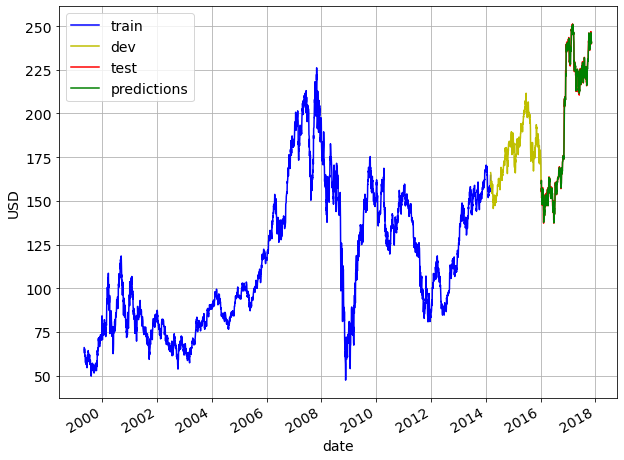

In [58]:
train, cv, train_cv, test = split_train_dev_test(df)
y_sample = test['adj_close']
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='r-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [49]:
print(train['date'])

3      1999-05-07
4      1999-05-10
5      1999-05-11
6      1999-05-12
7      1999-05-13
          ...    
3726   2014-02-28
3727   2014-03-03
3728   2014-03-04
3729   2014-03-05
3730   2014-03-06
Name: date, Length: 3728, dtype: datetime64[ns]


Text(0, 0.5, 'USD')

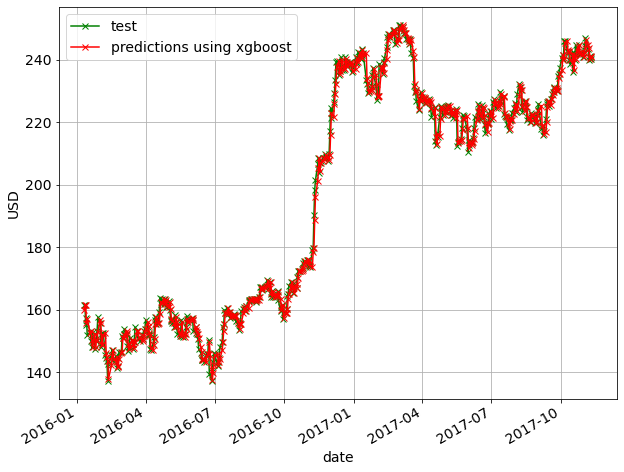

In [50]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [51]:
print(est)

4196    160.058514
4197    161.432992
4198    161.649055
4199    155.694963
4200    157.117588
           ...    
4656    244.722237
4657    243.690143
4658    240.140430
4659    241.140641
4660    240.827358
Length: 465, dtype: float64


# Estimate on a particular Day

In [52]:
print(est[df[df.date=='2017-11-10'].index[0]])

240.8273578272186
